In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import numpy as np
import torch.onnx
import torchvision
from sklearn.model_selection import train_test_split
%matplotlib inline

input_img_sz=11
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="../../data",    
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
    [torchvision.transforms.Resize(input_img_sz), torchvision.transforms.ToTensor()]
    ),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="../../data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(input_img_sz), torchvision.transforms.ToTensor()]
    ),
)

In [44]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 11x11
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                       
        self.fc1 = nn.Linear(25, 64)
        self.fc2 = nn.Linear(64, 10)
        

        
    def forward(self, x):
        # first conv
        x=self.conv1(x)
        con_result=x
        x= F.relu(x)
        x = self.pool(x)
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # print(np.amax(x.cpu().numpy()))
        

        return x

model = ConvNet().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Using cuda device
ConvNet(
  (conv1): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
Shape of X [N, C, H, W]: torch.Size([64, 1, 11, 11])
Shape of y: torch.Size([64]) torch.int64


In [62]:
img=torch.ones((1,11,11))
img=img.reshape(-1)
for i in range(121):
    img[i]=i
img=img.reshape(1,11,11)
img

tensor([[[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
         [ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.],
         [ 22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.],
         [ 33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.],
         [ 44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.],
         [ 55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.],
         [ 66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.],
         [ 77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.],
         [ 88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
         [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.],
         [110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.]]])

In [65]:
img,idx=test_data[2]
img=torch.ones((1,11,11))
img=img.reshape(-1)
for i in range(121):
    img[i]=i
img=img.reshape(1,11,11)
img=img.reshape((1,1,11,11)).to(device)
result=model(img)
print(result.argmax(),idx)

tensor([[[[  53.0010,   61.7964,   70.5918,   79.3871,   88.1825,   96.9779,
            105.7732,  114.5686,  123.3640,  132.1593],
          [ 149.7501,  158.5454,  167.3408,  176.1362,  184.9315,  193.7269,
            202.5223,  211.3177,  220.1130,  228.9084],
          [ 246.4991,  255.2945,  264.0899,  272.8852,  281.6806,  290.4760,
            299.2713,  308.0667,  316.8621,  325.6574],
          [ 343.2482,  352.0435,  360.8389,  369.6343,  378.4297,  387.2250,
            396.0204,  404.8158,  413.6111,  422.4065],
          [ 439.9973,  448.7926,  457.5880,  466.3834,  475.1787,  483.9741,
            492.7694,  501.5648,  510.3602,  519.1555],
          [ 536.7463,  545.5416,  554.3370,  563.1324,  571.9277,  580.7231,
            589.5185,  598.3138,  607.1092,  615.9046],
          [ 633.4953,  642.2906,  651.0861,  659.8814,  668.6768,  677.4722,
            686.2675,  695.0629,  703.8583,  712.6536],
          [ 730.2444,  739.0397,  747.8351,  756.6305,  765.4259,  77

5


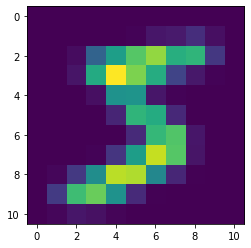

In [4]:
import matplotlib.pyplot as plt
img,idx =training_data[0]
print(idx)
plt.imshow(  img.permute(1, 2, 0)  )

In [48]:
model

ConvNet(
  (conv1): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [64]:
import os
file_name = "cnn_c_maxpool_f_f94.4.pth"
if not (os.path.isfile(file_name)):
    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)
        torch.save(model, file_name)
    print("Done!")
else:
    #model.load_state_dict(torch.load("model.pth"))
    model = torch.load( file_name)
    test(test_dataloader, model, loss_fn)
    print("Model loaded")

tensor([[[[0.0058, 0.0058, 0.0058,  ..., 0.0058, 0.0058, 0.0058],
          [0.0058, 0.2518, 0.6543,  ..., 0.1377, 0.0371, 0.0058],
          [0.0058, 0.9910, 2.6272,  ..., 2.1382, 0.6459, 0.0058],
          ...,
          [0.0058, 0.0058, 0.0058,  ..., 0.0697, 0.0058, 0.0058],
          [0.0058, 0.0058, 0.0720,  ..., 0.0058, 0.0058, 0.0058],
          [0.0058, 0.0058, 0.1757,  ..., 0.0058, 0.0058, 0.0058]]],


        [[[0.0058, 0.0152, 0.5516,  ..., 0.0371, 0.0058, 0.0058],
          [0.0058, 0.1936, 2.1760,  ..., 0.1677, 0.0058, 0.0058],
          [0.0058, 0.2250, 1.9411,  ..., 0.1990, 0.0058, 0.0058],
          ...,
          [0.0058, 0.1942, 3.0167,  ..., 3.7597, 3.7375, 2.5796],
          [0.0058, 0.0702, 1.2158,  ..., 2.8671, 2.3263, 1.4686],
          [0.0058, 0.0058, 0.0621,  ..., 0.1590, 0.0240, 0.0058]]],


        [[[0.0058, 0.0058, 0.0058,  ..., 0.2331, 0.0058, 0.0058],
          [0.0058, 0.0058, 0.0058,  ..., 0.6000, 0.0058, 0.0058],
          [0.0058, 0.0058, 0.0058,  ..

In [7]:
model = torch.load( file_name)
bit_range=8
for ele in model.state_dict():#turn to numpy
    model.state_dict()[ele]=model.state_dict()[ele].cpu().numpy()
#turn float to int
for layers in model.state_dict():
    try:
        (channel,num,row,col)=model.state_dict()[layers].shape
        for ch in range(channel):
            for r in range(row):
                for c in range(col):
                    num=int((model.state_dict()[layers][ch][0][r][c]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    model.state_dict()[layers][ch][0][r][c]=num
    except:
        try:
            model.state_dict()[layers].shape[1]## if parameter is 2D
            row,col=model.state_dict()[layers].shape
            for row in range(model.state_dict()[layers].shape[0]):
                for col in range(model.state_dict()[layers].shape[1]):
                    num=int((model.state_dict()[layers][row][col]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    model.state_dict()[layers][row][col]=num
        except:
            #model[layers].shape #1D
            # print(model[layers].shape[0])
            for i in range(model.state_dict()[layers].shape[0]):
                num=int((model.state_dict()[layers][i]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                model.state_dict()[layers][i]=num
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 91.6%, Avg loss: 382075.333350 



In [7]:
model = torch.load( file_name)
A=29
bit_range=8
for ele in model.state_dict():#turn to numpy
    model.state_dict()[ele]=model.state_dict()[ele].cpu().numpy()
#turn float to int
for layers in model.state_dict():
    try:
        (channel,num,row,col)=model.state_dict()[layers].shape
        for ch in range(channel):
            for r in range(row):
                for c in range(col):
                    num=int((model.state_dict()[layers][ch][0][r][c]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    num=round(num/A)*A
                    model.state_dict()[layers][ch][0][r][c]=num
    except:
        try:
            model.state_dict()[layers].shape[1]## if parameter is 2D
            row,col=model.state_dict()[layers].shape
            for row in range(model.state_dict()[layers].shape[0]):
                for col in range(model.state_dict()[layers].shape[1]):
                    num=int((model.state_dict()[layers][row][col]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    num=round(num/A)*A
                    model.state_dict()[layers][row][col]=num
        except:
            #model[layers].shape #1D
            # print(model[layers].shape[0])
            for i in range(model.state_dict()[layers].shape[0]):
                num=int((model.state_dict()[layers][i]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                num=round(num/A)*A
                model.state_dict()[layers][i]=num
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 85.3%, Avg loss: 877988.826035 



In [8]:
for ele in model.state_dict():
    print(ele,model.state_dict()[ele].shape)

conv1.weight torch.Size([1, 1, 2, 2])
conv1.bias torch.Size([1])
fc1.weight torch.Size([64, 25])
fc1.bias torch.Size([64])
fc2.weight torch.Size([10, 64])
fc2.bias torch.Size([10])


In [9]:
model.state_dict()["conv1.weight"]

tensor([[[[290., 261.],
          [261., 319.]]]], device='cuda:0')

In [136]:
img,idx=training_data[0]

In [133]:
filter0=model.state_dict()["conv1.weight"].cpu().numpy().reshape((5,5))

In [75]:
def five_five(img,filter,sz):
    #convolution
    #img 5x5 filter 5x5 
    # temp=np.zeros((5,5))
    img=img.reshape((sz,sz))
    filter=filter.reshape((sz,sz))
    convolution_result=0
    for col in range(sz):
        for row in range(sz):
            # convolution_result[col,row]=img[col][row]*filter[col][row]
            convolution_result+=img[col][row]*filter[col][row]
    return convolution_result

In [50]:
a=np.ones((5,5))
sz=3
a[0:sz,0:sz]
five_five(a,a,3)

9.0

In [39]:
def conv5x5(img,filter):
    img_sz=img.shape[1]
    temp=np.zeros((img_sz-5+1,img_sz-5+1))
    for col in range(img_sz-5+1):
        for row in range(img_sz-5+1):
            start_x,start_y=(col,row)
            part_img=img[0][start_x+0:start_x+5,start_y+0:start_y+5]
            temp[row,col]=five_five(part_img,filter,5)
    return temp
def conv_sz(img,filter,sz):
    img_sz=img.shape[1]
    temp=np.zeros((img_sz-sz+1,img_sz-sz+1))
    for col in range(img_sz-sz+1):
        for row in range(img_sz-sz+1):
            start_x,start_y=(col,row)
            part_img=img[0][start_x+0:start_x+sz,start_y+0:start_y+sz]
            temp[row,col]=five_five(part_img,filter,sz)
    return temp
def myconv(img,filter,sz):
    img_sz=img.shape[1]
    temp=np.zeros((img_sz-sz+1,img_sz-sz+1))
    for col in range(img_sz-sz+1):
        for row in range(img_sz-sz+1):
            start_x,start_y=(col,row)
            part_img=img[start_x+0:start_x+sz,start_y+0:start_y+sz]
            temp[row,col]=five_five(part_img,filter,sz)
    return temp

In [40]:
a=np.asarray(model.state_dict()["conv1.weight"].cpu())
a=a.reshape((2,2))
img=np.arange(1,17).reshape((4,4))
myconv(img,a,2)

array([[ 3944.,  8432., 12920.],
       [ 5066.,  9554., 14042.],
       [ 6188., 10676., 15164.]])

In [12]:
img=np.ones((1,6,6))
filter0=np.ones((5,5))
conv5x5(img,filter0)

array([[25., 25.],
       [25., 25.]])

In [13]:
model.state_dict()["conv1.weight"]

tensor([[[[297., 262.],
          [255., 308.]]]], device='cuda:0')

In [14]:
for ele in model.state_dict():
    print(ele,model.state_dict()[ele].shape)

conv1.weight torch.Size([1, 1, 2, 2])
conv1.bias torch.Size([1])
fc1.weight torch.Size([64, 25])
fc1.bias torch.Size([64])
fc2.weight torch.Size([10, 64])
fc2.bias torch.Size([10])


In [102]:
def myRelu(x):
    x_temp=x.reshape(-1)
    for idx,ele in enumerate(x_temp):
        if(ele<0):
            x_temp[idx]=0
    
    return x_temp.reshape(x.shape)
def myPool(x):#stride2
    step=int(x.shape[0]/2)
    sz=x.shape[0]
    temp=np.zeros((step,step))
    for col in range(step):
        for row in range(step):
            start_x,start_y=(row,col)
            temp[row][col]=np.amax(x[start_x*2+0:start_x*2+2,start_y*2+0:start_y*2+2])
    return temp
def FullyConnected(input_vector,weight_vector,bias_vector):
    sz=weight_vector.shape
    weight_vector=weight_vector.reshape(-1)
    output_vector=np.zeros(sz[0])
    for output_node in range(sz[0]):
        for input_node in range(sz[1]):
            output_vector[output_node]+=weight_vector[output_node*sz[1]+input_node]*input_vector[input_node]
        output_vector[output_node]+=bias_vector[output_node]
    return output_vector

In [16]:
x=np.arange(0,16).reshape(4,4)
print(x)
print(myPool(x))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 5.  7.]
 [13. 15.]]


7


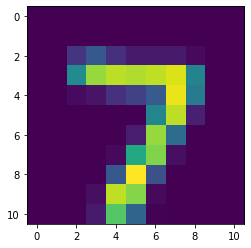

In [44]:
img,idx=test_data[0]
print(idx)
import matplotlib.pyplot as plt
plt.imshow(  img.permute(1, 2, 0)  )

In [53]:
con_f=np.asarray(model.state_dict()["conv1.weight"].cpu())

In [76]:
img,idx=test_data[0]
img_sz=img.shape[1]

temp=np.zeros((img_sz-2+1,img_sz-2+1))

for col in range(img_sz-2+1):
    for row in range(img_sz-2+1):
        start_x,start_y=(col,row)
        part_img=img[0][start_x+0:start_x+2,start_y+0:start_y+2]
        temp[row,col]=five_five(part_img,con_f,2)

In [105]:
def mynet(img):
    con_f=np.asarray(model.state_dict()["conv1.weight"].cpu())
    x=conv_sz(img,con_f,2)
    x=myRelu(x)
    x=myPool(x)
    x=x.reshape(-1)
    fc1_b=np.asarray(model.state_dict()["fc1.bias"].cpu())
    fc1_w=np.asarray(model.state_dict()["fc1.weight"].cpu())
    x=FullyConnected(x,fc1_w,fc1_b)
    x=myRelu(x)
    fc2_b=np.asarray(model.state_dict()["fc2.bias"].cpu())
    fc2_w=np.asarray(model.state_dict()["fc2.weight"].cpu())
    x=FullyConnected(x,fc2_w,fc2_b)
    x.argmax()


6

In [110]:
img,idx=test_data[4]
con_f=np.asarray(model.state_dict()["conv1.weight"].cpu())
x=conv_sz(img,con_f,2)
x=myRelu(x)
x=myPool(x)
x=x.reshape(-1)

fc1_b=np.asarray(model.state_dict()["fc1.bias"].cpu())
fc1_w=np.asarray(model.state_dict()["fc1.weight"].cpu())
x=FullyConnected(x,fc1_w,fc1_b)
x=myRelu(x)

fc2_b=np.asarray(model.state_dict()["fc2.bias"].cpu())
fc2_w=np.asarray(model.state_dict()["fc2.weight"].cpu())
x=FullyConnected(x,fc2_w,fc2_b)

print("predict",x.argmax(),"label",idx)

predict 2 label 4
